In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style="whitegrid")


df = pd.read_csv("../csv/telco-customer.csv")

print({df.shape})
df.head()

{(7043, 21)}


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print()
df.info()
print()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


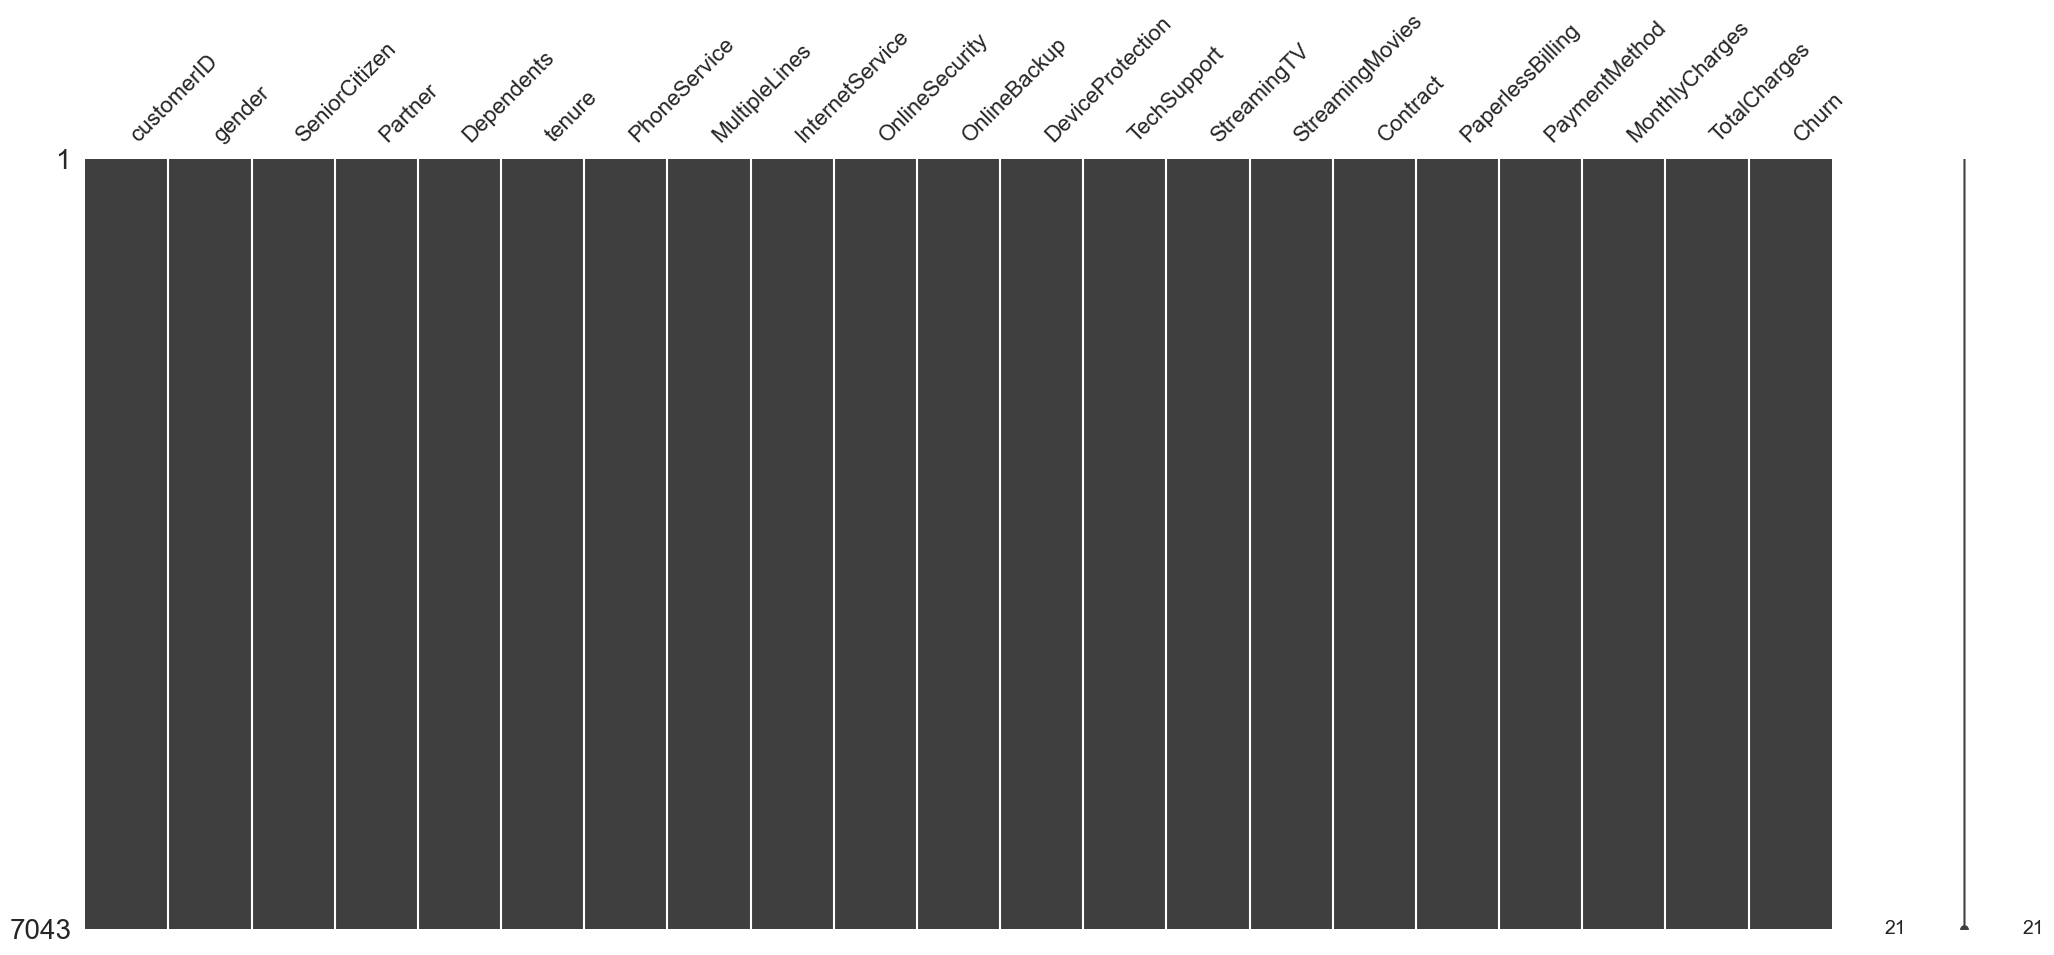

In [4]:
import missingno as msno

msno.matrix(df)
plt.show()

In [5]:
import gc

#Varables categóricas df_train
categorical_columns = df.select_dtypes(include=['object']).columns
unique_values = {col: df[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

gc.collect()

customerID: 7043 unique values
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


8358

In [6]:
categorical_columns = categorical_columns.drop(['customerID', 'TotalCharges'])

for col in categorical_columns:
    print(f"\n{col}")
    print(df[col].value_counts())


gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

PhoneService
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

OnlineBackup
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

DeviceProtection
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

TechSupport
TechSupport
No             

In [10]:
# Convertir todas las columnas categóricas a tipo category
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Verificar los cambios
print(df.dtypes)





'''MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaymentMethod: 4 unique values'''

customerID            object
gender              category
SeniorCitizen          int64
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges          object
Churn               category
dtype: object


'MultipleLines: 3 unique values\nInternetService: 3 unique values\nOnlineSecurity: 3 unique values\nOnlineBackup: 3 unique values\nDeviceProtection: 3 unique values\nTechSupport: 3 unique values\nStreamingTV: 3 unique values\nStreamingMovies: 3 unique values\nContract: 3 unique values\nPaymentMethod: 4 unique values'

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   int64   
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

In [12]:
# Eliminar la columna customerID
df = df.drop('customerID', axis=1)

# Verificar que se eliminó
print(df.head())

   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No  

In [14]:
# Convertir TotalCharges y MonthlyCharges a float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['MonthlyCharges'] = df['MonthlyCharges'].astype('float')


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   gender                  7043 non-null   category
 1   SeniorCitizen           7043 non-null   int64   
 2   Partner                 7043 non-null   category
 3   Dependents              7043 non-null   category
 4   tenure                  7043 non-null   int64   
 5   PhoneService            7043 non-null   category
 6   MultipleLines           7043 non-null   category
 7   InternetService         7043 non-null   category
 8   OnlineSecurity          7043 non-null   category
 9   OnlineBackup            7043 non-null   category
 10  DeviceProtection        7043 non-null   category
 11  TechSupport             7043 non-null   category
 12  StreamingTV             7043 non-null   category
 13  StreamingMovies         7043 non-null   category
 14  Contract                

In [16]:
# Crear columna cliente_larga_duracion
df['cliente_larga_duracion'] = (df['tenure'] >= 24).astype('category')

# Verificar la nueva columna
print(df['cliente_larga_duracion'].value_counts())
print(df[['tenure', 'cliente_larga_duracion']].head(10))

cliente_larga_duracion
True     3927
False    3116
Name: count, dtype: int64
   tenure cliente_larga_duracion
0       1                  False
1      34                   True
2       2                  False
3      45                   True
4       2                  False
5       8                  False
6      22                  False
7      10                  False
8      28                   True
9      62                   True


In [18]:
# Crear columna contrato_multiple
df['phone+internet'] = ((df['PhoneService'] == 'Yes') & (df['InternetService'] != 'No')).astype('category')

# Verificar la nueva columna
print(df['phone+internet'].value_counts())
print(df[['PhoneService', 'InternetService', 'phone+internet']].head(10))

phone+internet
True     4835
False    2208
Name: count, dtype: int64
  PhoneService InternetService phone+internet
0           No             DSL          False
1          Yes             DSL           True
2          Yes             DSL           True
3           No             DSL          False
4          Yes     Fiber optic           True
5          Yes     Fiber optic           True
6          Yes     Fiber optic           True
7           No             DSL          False
8          Yes     Fiber optic           True
9          Yes             DSL           True
